## Env and Model Prep

First we check the GPU version available in the environment and install specific dependencies that are compatible with the detected GPU to prevent version conflicts.

In [1]:
%%capture
import torch
major_version, minor_version = torch.cuda.get_device_capability()
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
if major_version >= 8:
    !pip install --no-deps packaging ninja einops flash-attn xformers trl peft accelerate bitsandbytes
else:
    !pip install --no-deps xformers trl peft accelerate bitsandbytes
pass

Next we need to prepare to load a range of quantized language models, including a new 15 trillion token LLama-3 model, optimized for memory efficiency with 4-bit quantization.


In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! Llama 3 is up to 8k
dtype = None
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
    "unsloth/gemma-7b-it-bnb-4bit",
    "unsloth/gemma-2b-bnb-4bit",
    "unsloth/gemma-2b-it-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",
]

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit", # Llama-3 70b also works (just change the model name)
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = True.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Run against SQuAD

### Data Prep

In [34]:
from datasets import load_dataset

# Load SQuAD dataset
include_impossible_questions = False
squad_dataset = load_dataset("squad_v2" if include_impossible_questions else "squad")
subset = squad_dataset['validation'].select(range(2000))

In [4]:
# Function to tokenize the data
def preprocess_function(examples):
    return tokenizer(
        examples['question'], examples['context'],
        truncation="only_first", padding="max_length", max_length=512, return_tensors="pt"
    )

In [35]:
train_test_split = subset.train_test_split(test_size=0.5)
train_dataset = train_test_split['train']
testPPP_dataset = train_test_split['test']

print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(testPPP_dataset)}")

Training set size: 1000
Testing set size: 1000


In [37]:
testPPP_dataset[0]

{'id': '56e1b00ce3433e14004230a1',
 'title': 'Computational_complexity_theory',
 'context': 'Many types of Turing machines are used to define complexity classes, such as deterministic Turing machines, probabilistic Turing machines, non-deterministic Turing machines, quantum Turing machines, symmetric Turing machines and alternating Turing machines. They are all equally powerful in principle, but when resources (such as time or space) are bounded, some of these may be more powerful than others.',
 'question': 'In the determination of complexity classes, what are two examples of types of Turing machines?',
 'answers': {'text': ['probabilistic Turing machines, non-deterministic Turing machines',
   'probabilistic Turing machines, non-deterministic Turing machines'],
  'answer_start': [108, 108]}}

In [36]:
train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = testPPP_dataset.map(preprocess_function, batched=True)

print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Training set size: 1000
Testing set size: 1000


In [38]:
print(test_dataset)

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'input_ids', 'attention_mask'],
    num_rows: 1000
})


### Evaluation

Without any constraint

In [7]:
from collections import Counter

def tokenize(text):
    # Use tokenizer to split the text into tokens, consider using a lowercasing to normalize
    return tokenizer.tokenize(text.lower())

def precision_recall_f1(prediction, truth):
    # Tokenize both prediction and truth
    prediction_tokens = Counter(tokenize(prediction))
    truth_tokens = Counter(tokenize(truth))

    # Calculate common token counts
    common_tokens = prediction_tokens & truth_tokens
    num_same = sum(common_tokens.values())

    if num_same == 0:
        return 0, 0, 0

    # Precision: proportion of predicted tokens that are correct
    precision = num_same / sum(prediction_tokens.values())

    # Recall: proportion of truth tokens that are predicted
    recall = num_same / sum(truth_tokens.values())

    # F1 Score: harmonic mean of precision and recall
    f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

# Compute scores for each prediction against each possible truth
def compute_metrics(predictions, truths):
    precision, recall, f1 = 0, 0, 0
    for prediction, truth in zip(predictions, truths):
        p, r, f = precision_recall_f1(prediction, truth['answers']['text'][0])  # Assuming only one truth per example
        precision += p
        recall += r
        f1 += f
    count = len(predictions)
    return precision / count, recall / count, f1 / count

In [ ]:
def prepare_input(context, question):
    return f"question: {question} context: {context} answer:"

def extract_answers(qa_list):
    answers = []
    for qa in qa_list:
        # Split the string at "answer:" and take the second part
        answer_part = qa.split("answer:")[-1]
        # Strip to remove any leading/trailing whitespace
        clean_answer = answer_part.strip()
        answers.append(clean_answer)
    return answers

def calc_exact_match_score(prediction, truth):
    #print(truth)
    return any(prediction.strip().lower() == true_answer.strip().lower() for true_answer in truth)

# Prepare inputs
formatted_inputs = [prepare_input(example['context'], example['question']) for example in testPPP_dataset]

inputs = tokenizer(formatted_inputs, padding=True, truncation=True, return_tensors="pt").to("cuda")

f1_scores = []
exact_match_scores = []

# Generate answers
for i in range(10):
  outputs = model.generate(**inputs, max_new_tokens=128)  # Adjust max_new_tokens if needed
  final_answers = tokenizer.batch_decode(outputs, skip_special_tokens=True)
  # Get the list of answers
  answers = extract_answers(final_answers)
  # Output the answers
  print(answers)
  # print(final_answers)
  # Compute the score
  exact_matches = sum(calc_exact_match_score(pred, example['answers']['text']) for pred, example in zip(final_answers, testPPP_dataset))
  exact_match_score = 100 * exact_matches / len(testPPP_dataset)
  print(f"Exact Match Score: {exact_match_score:.2f}%")

  precision, recall, f1_score = compute_metrics(answers, testPPP_dataset)
  print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1_score:.2f}")

  f1_scores.append(f1_score)
  exact_match_scores.append(exact_match_score)


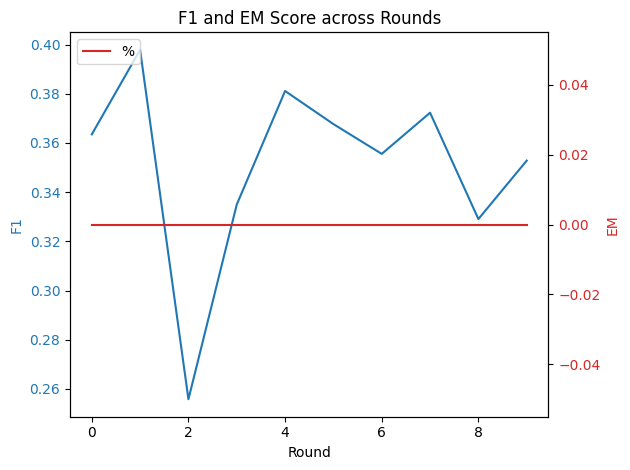

In [17]:
import matplotlib.pyplot as plt

# Setup plot and axes
fig, ax1 = plt.subplots()

# First data series
color = 'tab:blue'
ax1.set_xlabel('Round')
ax1.set_ylabel('F1', color=color)
ax1.plot(f1_scores, color=color, label='')
ax1.tick_params(axis='y', labelcolor=color)

# Second data series with secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('EM', color=color)
ax2.plot(exact_match_scores, color=color, label='%')
ax2.tick_params(axis='y', labelcolor=color)

# Title, legend, and layout
plt.title('F1 and EM Score across Rounds')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
fig.tight_layout()

# Display plot
plt.show()


With constraint of using only existing tokens

In [ ]:
def prepare_input(context, question):
    return f"question: {question} context: {context} answer:"

def extract_answers(qa_list, contexts):
    answers = []
    for qa, context in zip(qa_list, contexts):
        answer_part = qa.split("answer:")[-1].strip()
        # Tokenize context and answer for accurate comparison
        context_tokens = set(tokenizer.tokenize(context))
        answer_tokens = tokenizer.tokenize(answer_part)

        # Filter answer tokens to ensure all are in context
        filtered_answer_tokens = [token for token in answer_tokens if token in context_tokens]
        clean_answer = tokenizer.convert_tokens_to_string(filtered_answer_tokens)
        answers.append(clean_answer)
    return answers

# Prepare inputs
formatted_inputs = [prepare_input(example['context'], example['question']) for example in testPPP_dataset]
inputs = tokenizer(formatted_inputs, padding=True, truncation=True, return_tensors="pt").to("cuda")

f1_scores_with_constraint = []
exact_match_scores_with_constraint = []

for i in range(10):
  outputs = model.generate(**inputs, max_new_tokens=128)  # Adjust max_new_tokens if needed
  final_answers = tokenizer.batch_decode(outputs, skip_special_tokens=True)
  # Extract contexts for use in answer extraction
  contexts = [example['context'] for example in testPPP_dataset]
  # Get the list of answers
  answers = extract_answers(final_answers, contexts)

  # Compute the score
  exact_matches = sum(calc_exact_match_score(pred, example['answers']['text']) for pred, example in zip(answers, testPPP_dataset))
  exact_match_score = 100 * exact_matches / len(testPPP_dataset)
  print(f"Exact Match Score: {exact_match_score:.2f}%")

  precision, recall, f1_score = compute_metrics(answers, testPPP_dataset)
  print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1_score:.2f}")

  f1_scores_with_constraint.append(f1_score)
  exact_match_scores_with_constraint.append(exact_match_score)


In [ ]:
for pred, example in zip(answers, testPPP_dataset):
  print(pred, example['answers']['text'])
  print()

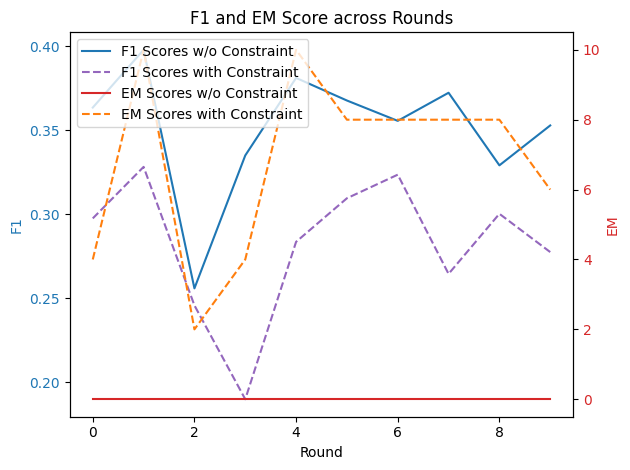

In [21]:
import matplotlib.pyplot as plt

# Setup plot and axes
fig, ax1 = plt.subplots()

# First data series (original F1 scores)
color = 'tab:blue'
ax1.set_xlabel('Round')
ax1.set_ylabel('F1', color=color)
ax1.plot(f1_scores, color=color, linestyle='-', label='F1 Scores w/o Constraint')  # Added label for clarity
ax1.tick_params(axis='y', labelcolor=color)

# New data series (F1 scores with constraints)
color = 'tab:purple'  # Using a different color
ax1.plot(f1_scores_with_constraint, color=color, linestyle='--', label='F1 Scores with Constraint')

# Second data series (original EM scores)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('EM', color=color)
ax2.plot(exact_match_scores, color=color, linestyle='-', label='EM Scores w/o Constraint')
ax2.tick_params(axis='y', labelcolor=color)

# New data series (EM scores with constraints)
color = 'tab:orange'  # Using a different color
ax2.plot(exact_match_scores_with_constraint, color=color, linestyle='--', label='EM Scores with Constraint')

# Title, legend, and layout
plt.title('F1 and EM Score across Rounds')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
fig.tight_layout()

plt.savefig('F1_and_EM_Scores.png', format='png', dpi=300)
# Display plot
plt.show()


In [ ]:
# Apply preprocessing to both training and testing sets
# train_dataset = train_dataset.map(preprocess_function, batched=True)
# test_dataset = test_dataset.map(preprocess_function, batched=True)

# Adjust format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

from torch.utils.data import DataLoader

# Create DataLoaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# def predict_answer(question, context):
#     inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")
#     inputs = {k: v.to(model.device) for k, v in inputs.items()}

#     with torch.no_grad():
#         outputs = model(**inputs)
#         answer_start = torch.argmax(outputs.start_logits)
#         answer_end = torch.argmax(outputs.end_logits) + 1  # +1 to include the end token position

#     answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
#     return answer

In [ ]:
from transformers import AutoModelForQuestionAnswering
import torch

# Load the model
# model = AutoModelForQuestionAnswering.from_pretrained("bert-base-uncased")  # Change this to your model
model.eval()

# Function to get predictions
def get_predictions(data_loader):
    all_answers = []
    for batch in data_loader:
        input_ids = batch['input_ids'] #.to(torch.device('cuda'))
        attention_mask = batch['attention_mask'] #.to(torch.device('cuda'))
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
        # Extract the answers from the outputs here
        # This is just a placeholder
        print(len(outputs.logits))
        print(tokenizer.batch_decode(outputs))

        answers = tokenizer.decode(outputs.logits.argmax(dim=-1))
        print(answers)  # Simplified; actual extraction depends on your setup
        # start_logits
        all_answers.extend(answers)
    return all_answers

# Obtain predictions
predictions = get_predictions(test_loader)
a = 0


In [ ]:
# Function to compute exact match score
def exact_match_score(prediction, truth):
    return prediction.strip().lower() == truth.strip().lower()

def compute_em(predictions, ground_truths):
    total = len(predictions)
    exact_match_count = sum(exact_match_score(pred, truth) for pred, truth in zip(predictions, ground_truths))
    return 100 * exact_match_count / total

# Compute EM score using your previously obtained `predictions`
print(test_dataset[0])
ground_truths = [example['answers']['text'][0] for example in test_dataset]
em_score = compute_em(predictions, ground_truths)
print(f"Exact Match Score: {em_score:.2f}%")


In [ ]:
ground_truths = [example['answers'] for example in test_dataset]  # adjust as needed based on dataset structure

em_score = compute_em(predictions, ground_truths)
print(f"Exact Match Score: {em_score:.2f}%")




---



## Fine tune

Next, we integrate LoRA adapters into our model, which allows us to efficiently update just a fraction of the model's parameters, enhancing training speed and reducing computational load.

In [28]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use a new set of SQuAD as finetune data

Then, we define a system prompt that formats tasks into instructions, inputs, and responses, and apply it to a dataset to prepare our inputs and outputs for the model, with an EOS token to signal completion.


In [26]:
# Load SQuAD dataset
include_impossible_questions = False
squad_dataset = load_dataset("squad_v2" if include_impossible_questions else "squad")
subset = squad_dataset['validation'].select(range(1000))

# this is basically the system prompt
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. Only use tokens from the original context.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    instructions = examples["question"]
    inputs       = examples["context"]
    outputs      = examples["answers"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN # without this token generation goes on forever!
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = subset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

<a name="Train"></a>
### Train the model
- We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`.
- At this stage, we're configuring our model's training setup, where we define things like batch size and learning rate, to teach our model effectively with the data we have prepared.

In [29]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60, # increase this to make the model learn "better"
        # num_train_epochs=None,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `dataset_num_proc` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:307: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was c

Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [30]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.168 GB.
15.613 GB of memory reserved.


In [31]:
# We're now kicking off the actual training of our model, which will spit out some statistics showing us how well it learns
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,2.256400
2,2.021600
3,2.204200
4,2.041000
5,1.732200
6,1.991600
7,1.445100
8,1.508500
9,1.315500
10,1.376400


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

### Evaluation


In [ ]:
formatted_inputs = [prepare_input(example['context'], example['question']) for example in testPPP_dataset]

inputs = tokenizer(formatted_inputs, padding=True, truncation=True, return_tensors="pt").to("cuda")

f1_scores = []
exact_match_scores = []

# Generate answers
for i in range(10):
  outputs = model.generate(**inputs, max_new_tokens=128)  # Adjust max_new_tokens if needed
  final_answers = tokenizer.batch_decode(outputs, skip_special_tokens=True)
  # Get the list of answers
  answers = extract_answers(final_answers)
  # Output the answers
  print(answers)
  # print(final_answers)
  # Compute the score
  exact_matches = sum(calc_exact_match_score(pred, example['answers']['text']) for pred, example in zip(final_answers, testPPP_dataset))
  exact_match_score = 100 * exact_matches / len(testPPP_dataset)
  print(f"Exact Match Score: {exact_match_score:.2f}%")

  precision, recall, f1_score = compute_metrics(answers, testPPP_dataset)
  print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1_score:.2f}")

  f1_scores.append(f1_score)
  exact_match_scores.append(exact_match_score)